<a href="https://colab.research.google.com/github/tdejaeger/Epita_lectures/blob/main/IA_images_Lab2_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow


#**🧪 1. Coin Detection & Total Value Estimation**


In [52]:
img=files.upload()


Saving coins.jpeg to coins.jpeg


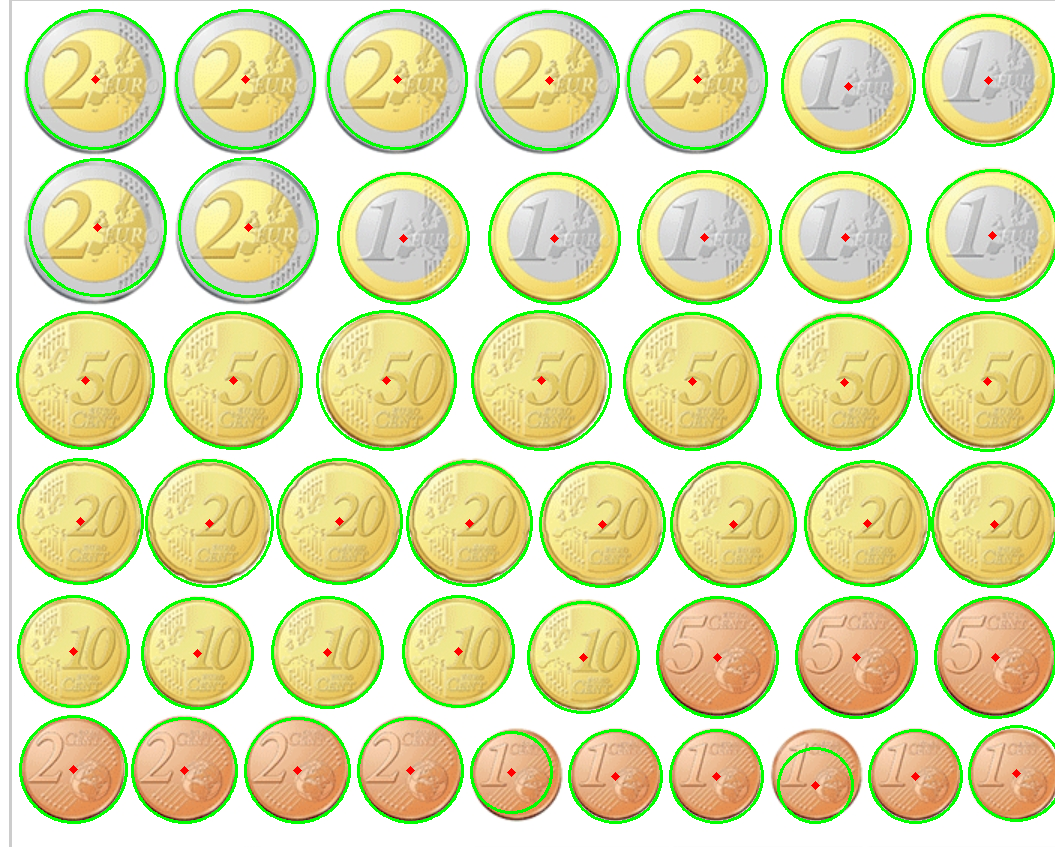

In [53]:
img = cv2.imread("coins.jpeg")

# Load the image
img = cv2.imread("coins.jpeg")
output = img.copy()  # This is where we'll draw

# Preprocessing
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 3)

# Circle detection
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
    param1=100, param2=30, minRadius=10, maxRadius=70
)

# Check and draw circles
circles = np.uint16(np.around(circles[0, :]))
for idx, (x, y, r) in enumerate(circles):
    cv2.circle(output, (x, y), r, (0, 255, 0), 2)     # Outer circle
    cv2.circle(output, (x, y), 2, (0, 0, 255), 3)     # Center point

# Show result
cv2_imshow(output)

In [54]:
 # We will do a selection by size but also for color.
 # size is 2,0.50,1,0.20,0.10,0.05,0.02,0.01
 # 2 color for 2 and 1 euros
 def get_dominant_hsv_color(image, x, y, r):
    """
    Extract the mean HSV color of a circular coin region.

    Parameters:
        image (np.array): Original BGR image.
        x, y (int): Center coordinates of the circle.
        r (int): Radius of the circle.

    Returns:
        (H, S, V): Tuple of mean hue, saturation, and value.
    """
    # Crop square region around the circle
    x1, y1 = max(0, x - r), max(0, y - r)
    x2, y2 = x + r, y + r
    coin = image[y1:y2, x1:x2]

    # Convert to HSV
    hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV)

    # Create circular mask
    mask = np.zeros((coin.shape[0], coin.shape[1]), dtype=np.uint8)
    center = (r, r)
    cv2.circle(mask, center, r, 255, -1)

    # Calculate mean HSV within the circle
    mean = cv2.mean(hsv, mask=mask)
    return mean[:3]  # Return H, S, V


In [141]:
h, s, v = get_dominant_hsv_color(img, x=circles[0][0], y=circles[0][1], r=circles[0][2])

24.214694419106063 115.32656107471598 228.61066423418194


In [55]:
#Obtain all the hue for each circles
hue_coin=[]
radius_coin=[]

for i in range(np.shape(circles)[0]):
  hue_coin.append(get_dominant_hsv_color(img, x=circles[i][0], y=circles[i][1], r=circles[i][2])[0])
  radius_coin.append(int(circles[i][2]))

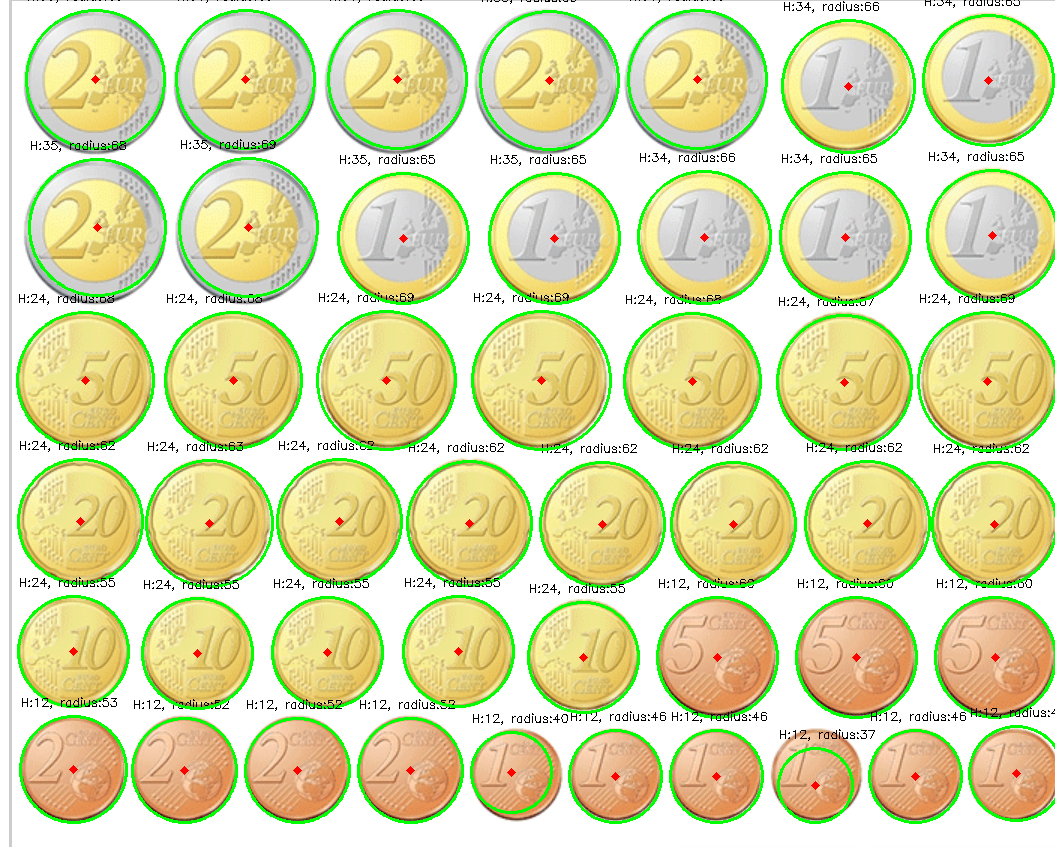

In [56]:
for i, (x, y, r) in enumerate(circles):
    hsv = get_dominant_hsv_color(img, x, y, r)
    if hsv is None:
        continue
    h, s, v = hsv
    label = f"H:{int(h)}, radius:{int(r)} "
    # Draw circle
    cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    cv2.circle(output, (x, y), 2, (0, 0, 255), 3)
    # Put text label
    cv2.putText(output, label, (x - r, y - r - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

# Show final annotated image
cv2_imshow(output)


In [57]:
def classify_coin(hue, radius):
    if 5 <= hue <= 15:  # Copper coins
        if (0 <= radius) & (radius <49):
            return "1c"
        elif (50 <= radius) & (radius <55):
            return "2c"
        elif (55 <= radius):
            return "5c"

    elif 20 <= hue <= 30:  # Gold coins (10c to 50c)
        if (0 <= radius) & (radius <60):
            return "10c"
        elif (56 <= radius) & (radius <=63):
            return "20c"
        elif (63 < radius):
            return "50c"
    elif hue>30:
         if (0 <= radius) & (radius <=66):

            return "1€"
         else:
            return "2€"

In [58]:
from collections import Counter
coin_counts = Counter()
for i, (h, r) in enumerate(list(zip(hue_coin, radius_coin))):
    coin_type = classify_coin(h, r)
    coin_counts[coin_type] += 1
coin_counts

Counter({'50c': 7,
         '5c': 3,
         '20c': 8,
         '2€': 7,
         '10c': 5,
         '2c': 4,
         '1€': 7,
         '1c': 6})

In [59]:
coin_values = {
    '1c': 0.01,
    '2c': 0.02,
    '5c': 0.05,
    '10c': 0.10,
    '20c': 0.20,
    '50c': 0.50,
    '1€': 1.00,
    '2€': 2.00
}
total = sum(coin_counts[k] * coin_values[k] for k in coin_counts)
print(f"Total amount: €{total:.2f}")

Total amount: €26.89


#**🧪 2. Shape Matching using Contours**



In [5]:
img=files.upload()


Saving shapes.png to shapes.png


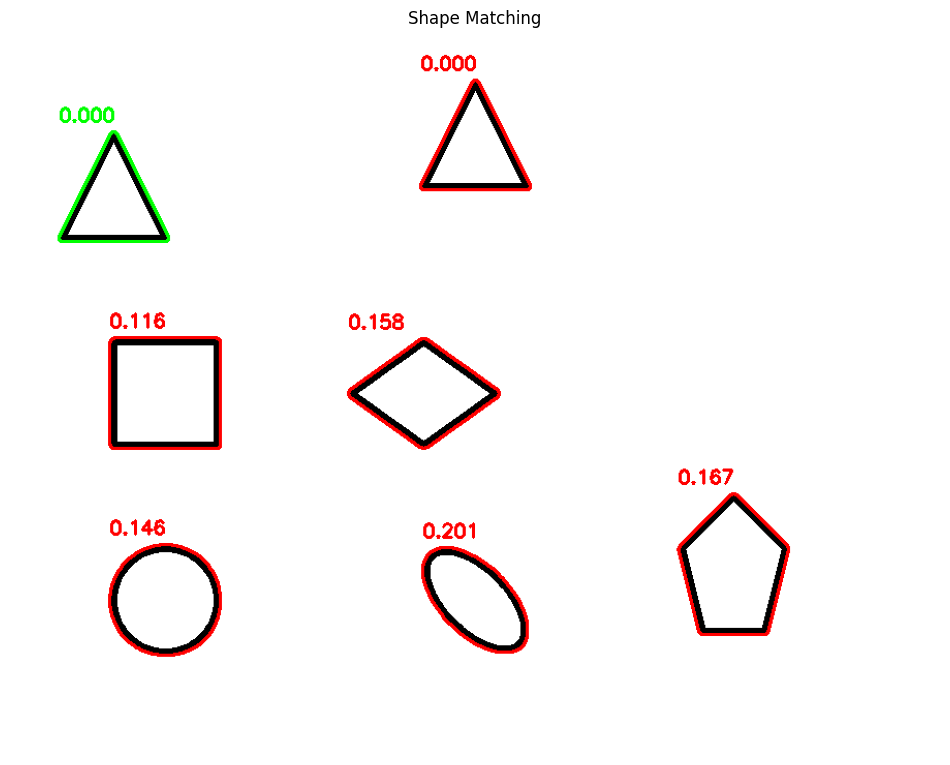

In [12]:
image = cv2.imread("shapes.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection and clean contour extraction
edges = cv2.Canny(gray, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and sort contours by area (largest first)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]

# Use one figure as template
idx_temp=5
temp_contour = contours[idx_temp]
output = image.copy()

# Draw and compare all contours
for idx, cnt in enumerate(contours):
    score = cv2.matchShapes(ref_contour, cnt, cv2.CONTOURS_MATCH_I1, 0.0)
    x, y, w, h = cv2.boundingRect(cnt)
    label = f"{score:.3f}"
    color = (0, 255, 0) if idx == idx_temp else (0, 0, 255)  # Green for reference, red otherwise
    cv2.drawContours(output, [cnt], -1, color, 2)
    cv2.putText(output, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display the result
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Shape Matching")
plt.axis("off")
plt.show()

#**🧪 3. Edge Detection: Sobel, Laplacian, and Canny**

In [13]:
img=files.upload()


Saving edgedetection.png to edgedetection.png


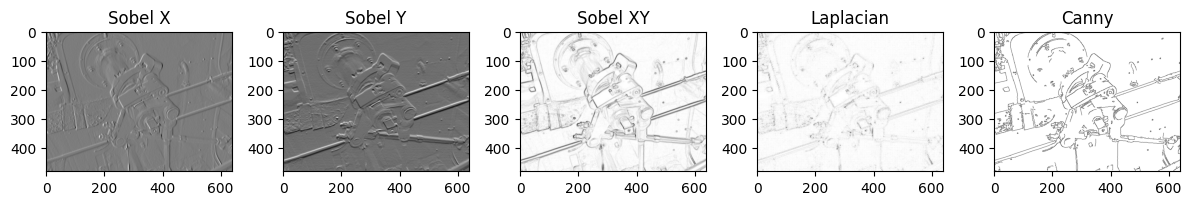

In [38]:
image = cv2.imread("edgedetection.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Remove noise
gray = cv2.GaussianBlur(gray, (3, 3), 0.5)

#Sobel
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
sobelxy = cv2.magnitude(sobelx, sobely)

sobel_mag = cv2.normalize(sobelxy, None, 0, 255, cv2.NORM_MINMAX)
sobel_mag = np.uint8(sobel_mag)
sobel_inverted = cv2.bitwise_not(sobel_mag)

#Canny
canny = cv2.Canny(gray, 100, 200)
canny_mag = cv2.normalize(canny, None, 0, 255, cv2.NORM_MINMAX)
canny_mag = np.uint8(canny_mag)
canny_inverted = cv2.bitwise_not(canny_mag)

# Laplacian
laplacian_64f = cv2.Laplacian(gray, cv2.CV_64F)
laplacian_abs = cv2.convertScaleAbs(laplacian_64f)
laplacian_inverted = cv2.bitwise_not(laplacian_abs)

#Note for each filter, we normalize and inverted for a better visualization

plt.figure(figsize=(12, 6))
plt.subplot(1, 5, 1)
plt.imshow(sobelx, cmap='gray'); plt.title("Sobel X")
plt.subplot(1, 5, 2)
plt.imshow(sobely, cmap='gray'); plt.title("Sobel Y")
plt.subplot(1, 5, 3)
plt.imshow(sobel_inverted, cmap='gray'); plt.title("Sobel XY")
plt.subplot(1, 5, 4)
plt.imshow(laplacian_inverted, cmap='gray'); plt.title("Laplacian")
plt.subplot(1, 5, 5)
plt.imshow(canny_inverted, cmap='gray'); plt.title("Canny")
plt.tight_layout(); plt.show()

#**🧪 4. Create Your Own Custom Filter**

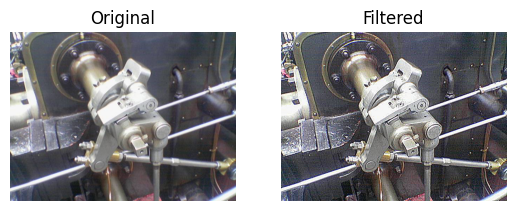

In [47]:
image = cv2.imread("edgedetection.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])

filtered = cv2.filter2D(src=image.copy(), ddepth=-1, kernel=kernel)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)); plt.title("Filtered"); plt.axis("off")
plt.show()

#**🧪 5. BONUS: Hough Line Detection**

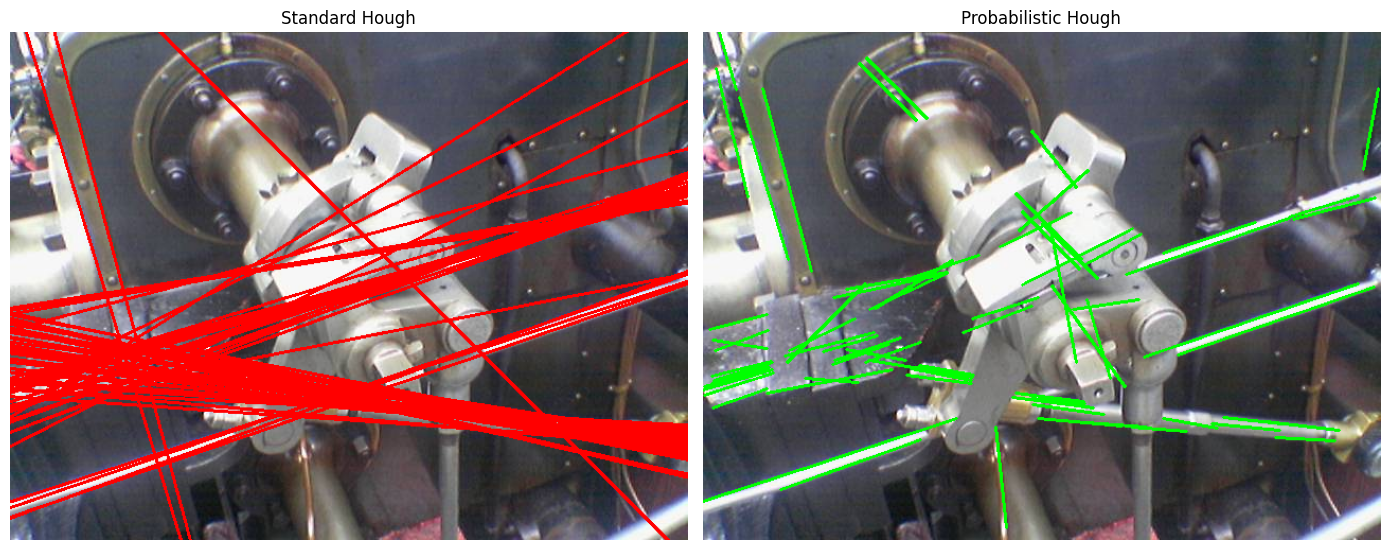

In [50]:
image = cv2.imread("edgedetection.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

#Line detection with Hough Line Transform
lines_std = cv2.HoughLines(edges, 1, np.pi / 180, 120)
img_std = image.copy()
if lines_std is not None:
    for rho_theta in lines_std:
        rho, theta = rho_theta[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_std, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Probabilistic Hough Line Transform
lines_prob = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
img_prob = image.copy()
if lines_prob is not None:
    for line in lines_prob:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_prob, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Figure
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_std, cv2.COLOR_BGR2RGB))
plt.title("Standard Hough")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_prob, cv2.COLOR_BGR2RGB))
plt.title("Probabilistic Hough")
plt.axis("off")

plt.tight_layout()
plt.show()